In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDCHF'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,slope_3,slope_4,slope_5,slope_10,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,1.6300,1.6399,1.6250,1.6249,0.0,186.877076,-60.668894,-169.372463,-239.644299,...,0.837781,1.556250,1.050995,1.625115,0.013908,-5.543634,1.63610,1.62045,1.628275,1.63245
30,14/2/2000,1.6249,1.6448,1.6195,1.6436,1.0,157.549786,203.849364,102.231466,-231.796192,...,2.061600,1.998262,2.725000,1.626710,0.014161,17.908963,1.64235,1.62225,1.632300,1.63215
31,15/2/2000,1.6436,1.6441,1.6285,1.6360,0.0,299.003322,203.849364,250.456760,-215.694318,...,0.214395,1.589667,1.526623,1.627890,0.013794,8.417617,1.64445,1.62400,1.634225,1.63630
32,16/2/2000,1.6360,1.6397,1.6248,1.6255,0.0,-333.624073,-29.697316,191.702317,-205.741105,...,-1.329367,-0.428790,0.937655,1.628013,0.012748,-53.821834,1.64190,1.62665,1.634275,1.63225
33,17/2/2000,1.6255,1.6303,1.6112,1.6235,0.0,-138.851623,-179.095549,-181.679526,-228.850801,...,-1.992152,-1.450771,-0.551302,1.627277,0.011668,-119.882934,1.63500,1.61800,1.626500,1.62075


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,slope_3,slope_4,slope_5,slope_10,slope_20,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,1.6399,1.6300,1.6250,1.6249,186.877076,-60.668894,-169.372463,-239.644299,181.616555,...,0.837781,1.556250,1.050995,1.625115,0.013908,-5.543634,1.63610,1.62045,1.628275,1.63245
30,14/2/2000,1.6448,1.6249,1.6195,1.6436,157.549786,203.849364,102.231466,-231.796192,177.422888,...,2.061600,1.998262,2.725000,1.626710,0.014161,17.908963,1.64235,1.62225,1.632300,1.63215
31,15/2/2000,1.6441,1.6436,1.6285,1.6360,299.003322,203.849364,250.456760,-215.694318,170.938026,...,0.214395,1.589667,1.526623,1.627890,0.013794,8.417617,1.64445,1.62400,1.634225,1.63630
32,16/2/2000,1.6397,1.6360,1.6248,1.6255,-333.624073,-29.697316,191.702317,-205.741105,156.266507,...,-1.329367,-0.428790,0.937655,1.628013,0.012748,-53.821834,1.64190,1.62665,1.634275,1.63225
33,17/2/2000,1.6303,1.6255,1.6112,1.6235,-138.851623,-179.095549,-181.679526,-228.850801,115.047013,...,-1.992152,-1.450771,-0.551302,1.627277,0.011668,-119.882934,1.63500,1.61800,1.626500,1.62075


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.82676878, 0.82525418, 0.83120529, ..., 0.82927609, 0.82660873,
        0.8281357 ],
       [0.83123632, 0.82062455, 0.82622476, ..., 0.8309203 , 0.83031014,
        0.82786174],
       [0.8305981 , 0.83759985, 0.83437472, ..., 0.83251884, 0.83208037,
        0.83165152],
       ...,
       [0.21936543, 0.2290305 , 0.23625826, ..., 0.23544188, 0.22380854,
        0.22396238],
       [0.21717724, 0.22567175, 0.23163995, ..., 0.23096597, 0.22031404,
        0.22053787],
       [0.21334792, 0.22076979, 0.23173051, ..., 0.22868235, 0.21764719,
        0.21866581]])

In [10]:
input_data.shape

(5212, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.82676878, 0.82525418, 0.83120529, ..., 0.82927609, 0.82660873,
        0.8281357 ],
       [0.83123632, 0.82062455, 0.82622476, ..., 0.8309203 , 0.83031014,
        0.82786174],
       [0.8305981 , 0.83759985, 0.83437472, ..., 0.83251884, 0.83208037,
        0.83165152],
       ...,
       [0.21936543, 0.2290305 , 0.23625826, ..., 0.23544188, 0.22380854,
        0.22396238],
       [0.21717724, 0.22567175, 0.23163995, ..., 0.23096597, 0.22031404,
        0.22053787],
       [0.21334792, 0.22076979, 0.23173051, ..., 0.22868235, 0.21764719,
        0.21866581]])

In [13]:
input_data[[0],1:]

array([[0.82525418, 0.83120529, 0.82062455, 0.67497231, 0.71452637,
        0.32328186, 0.40453065, 0.48794694, 0.54729498, 0.823912  ,
        0.62133851, 0.52655526, 0.48871637, 0.39486381, 0.38751258,
        0.37090276, 0.47235961, 0.42507645, 0.39486381, 0.38751258,
        0.37090276, 0.54427889, 0.52354031, 0.53421216, 0.51659715,
        0.83733562, 0.82125428, 0.5346943 , 0.82390519, 0.82927609,
        0.82660873, 0.8281357 ]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.82525418, 0.83120529, 0.82062455, ..., 0.82927609,
          0.82660873, 0.8281357 ]],

        [[0.82062455, 0.82622476, 0.83759985, ..., 0.8309203 ,
          0.83031014, 0.82786174]],

        [[0.83759985, 0.83437472, 0.8307008 , ..., 0.83251884,
          0.83208037, 0.83165152]],

        ...,

        [[0.84204793, 0.85239518, 0.8595679 , ..., 0.84201873,
          0.84373635, 0.85201589]],

        [[0.8595679 , 0.86235624, 0.86120189, ..., 0.85983101,
          0.8589328 , 0.86082827]],

        [[0.86120189, 0.86923843, 0.86701162, ..., 0.8683261 ,
          0.86670345, 0.86744897]]],


       [[[0.82062455, 0.82622476, 0.83759985, ..., 0.8309203 ,
          0.83031014, 0.82786174]],

        [[0.83759985, 0.83437472, 0.8307008 , ..., 0.83251884,
          0.83208037, 0.83165152]],

        [[0.8307008 , 0.83102418, 0.82116921, ..., 0.83493948,
          0.83212635, 0.82795306]],

        ...,

        [[0.8595679 , 0.86235624, 0.86120189, ..., 0.85983101,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4646, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4646/4646 [==============================] - 11s 2ms/step - loss: 0.0069
Epoch 2/5
4646/4646 [==============================] - 11s 2ms/step - loss: 3.3282e-04
Epoch 3/5
4646/4646 [==============================] - 12s 3ms/step - loss: 2.

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([0.9399, 0.9375, 0.9296, 0.9288, 0.932 , 0.937 , 0.9397, 0.9409,
       0.9374, 0.9391, 0.9417, 0.9458, 0.9491, 0.9424, 0.9408, 0.9419,
       0.9443, 0.952 , 0.9535, 0.9514, 0.9494, 0.948 , 0.952 , 0.9548,
       0.9552, 0.957 , 0.9567, 0.9515, 0.9497, 0.9489, 0.9509, 0.9578,
       0.9584, 0.9566, 0.9565, 0.9597, 0.9612, 0.964 , 0.9649, 0.961 ,
       0.9581, 0.9597, 0.9646, 0.9639, 0.9637, 0.9678, 0.9699, 0.9724,
       0.976 , 0.9789, 0.981 , 0.9848, 0.9896, 0.992 , 0.9921, 0.997 ,
       1.    , 0.9999, 1.0023, 1.0056, 1.0045, 1.0056, 1.0057, 1.004 ,
       1.0008, 1.0042, 1.0019, 1.0033, 1.0018, 1.0002, 0.9991, 0.9978,
       0.9958, 0.9937, 0.9958, 0.9983, 0.9935, 0.9897, 0.9913, 0.9894,
       0.9893, 0.9886, 0.9868, 0.9888, 0.9874, 0.9884, 0.9895, 0.9973,
       0.9988, 0.999 , 0.9978, 0.9983, 0.9986, 0.993 , 0.9904, 0.9923,
       0.9976, 0.9993, 0.9982, 0.9966, 0.995 , 0.994 , 0.9944, 0.9944,
       0.993 , 0.9962, 0.9966, 1.0027, 1.0068, 1.005 , 1.0002, 1.0035,
      

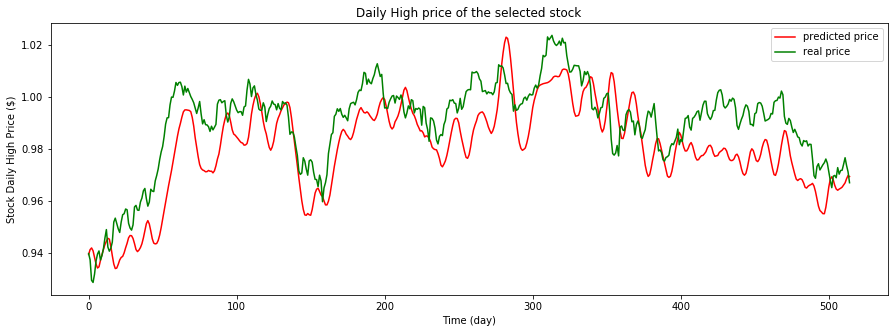

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,0.9399,0.939530,NaN,NaN
1,0.9375,0.941399,0.939530,0.001869
2,0.9296,0.942052,0.941399,0.000653
3,0.9288,0.940961,0.942052,-0.001091
4,0.9320,0.938383,0.940961,-0.002578
...,...,...,...,...
510,0.9742,0.966225,0.965403,0.000821
511,0.9767,0.967053,0.966225,0.000828
512,0.9737,0.968639,0.967053,0.001586
513,0.9713,0.969862,0.968639,0.001223


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,0.9399,0.939530,NaN,NaN,NaN,0.935500,NaN
1,0.9375,0.941399,0.939530,0.001869,0.398714,0.931200,-0.004596
2,0.9296,0.942052,0.941399,0.000653,0.140573,0.923675,-0.008081
3,0.9288,0.940961,0.942052,-0.001091,-0.235004,0.925850,0.002355
4,0.9320,0.938383,0.940961,-0.002578,-0.553297,0.929325,0.003753
5,0.9370,0.935900,0.938383,-0.002483,-0.529982,0.934475,0.005542
6,0.9397,0.934341,0.935900,-0.001559,-0.331797,0.938000,0.003772
7,0.9409,0.934798,0.934341,0.000457,0.097210,0.934775,-0.003438
8,0.9374,0.937250,0.934798,0.002452,0.523117,0.935675,0.000963
9,0.9391,0.939468,0.937250,0.002218,0.472347,0.936925,0.001336


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

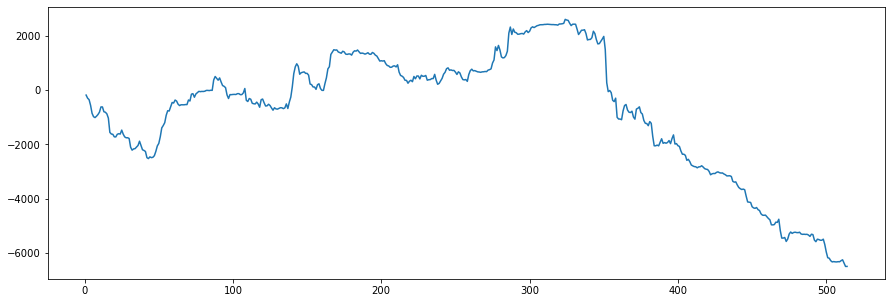

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-1.4163311850738476

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

0.8351254480286738

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 2522.430008106015 , from day 0 , to day 43
